In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import os
import datetime

from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio, xarray_to_rasterio_by_band

In [2]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    da.values[da.values == -28672] = np.nan
    da.values[da.values == 0] = np.nan
    
    #da.values = da.values.astype(np.float64)
    
    time_str = os.path.basename(filename)[17:28]
    print(time_str)
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

In [3]:
files = sorted(glob('ForVFPoC/2003/Projected/*_projPM25.tif'))

In [4]:
list_of_das = map(maiac_file_to_da, files)

In [5]:
res = xr.concat(list_of_das, 'time')

20030981210
20030981350
20030981525
20030991115
20030991255
20030991430
20031001200
20031001335
20031001515
20031011240
20031011420
20031021145
20031021325
20031021500
20031031230
20031031405
20031041135
20031041310
20031041450
20031051215
20031051355
20031051535
20031061120
20031061300
20031061440
20031071205
20031071340
20031071520
20031081250
20031081425
20031091150
20031091330
20031091510
20031101235
20031101415
20031111140
20031111320
20031111455
20031121225
20031121400
20031121540
20031131125
20031131305
20031131445
20031141210
20031141350
20031141525
20031151115
20031151255
20031151430
20031061115
20031061255
20031061430


In [6]:
newres = res.isel(time=np.argsort(res.time))

In [7]:
len(newres)

53

In [8]:
r = newres.resample('D', dim='time', how='max')

In [9]:
res.shape

(53, 1162, 1240)

In [10]:
r = r.dropna(dim='time', how='all')

In [18]:
xarray_to_rasterio??

In [11]:
aff = rasterio.Affine.from_gdal(*r.attrs['affine'])

In [12]:
import rasterstats

In [13]:
arr = r.isel(time=[0,1,2,3,4]).values

In [14]:
overall_mean = r.mean(dim='time', keep_attrs=True)

In [16]:
rasterstats.zonal_stats('nuts3_OSGB.json', overall_mean.values, affine=aff, nodata=np.nan, raster_out=True)

[{'count': 193,
  'max': nan,
  'mean': nan,
  'min': nan,
  'mini_raster_affine': Affine(1256.543044095589, 0.0, 434557.7179944995,
       0.0, -1256.543044095589, 538388.7937454027),
  'mini_raster_array': masked_array(data =
   [[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --]
   [-- -- -- -- -- -- -- -- -- nan nan nan -- -- -- --]
   [-- -- -- -- -- -- -- -- nan nan nan nan nan -- -- --]
   [-- -- -- -- -- -- -- -- nan nan nan nan nan nan nan --]
   [-- -- -- -- -- -- -- nan nan nan nan nan nan nan -- --]
   [-- -- -- -- -- -- -- nan nan nan nan nan nan nan -- --]
   [-- -- -- -- -- -- 19.90658187866211 16.898897171020508 nan nan nan nan
    nan nan -- --]
   [-- -- -- -- -- -- 19.84136390686035 16.91560935974121 nan nan nan nan nan
    nan nan --]
   [-- -- -- -- 19.94559669494629 19.86078643798828 20.204187393188477
    20.204376220703125 nan nan nan nan nan nan nan --]
   [-- -- -- -- 19.880210876464844 20.22394371032715 20.18977165222168
    18.094236373901367 nan nan nan nan 

In [111]:
xarray_to_rasterio_by_band(r, 'ForVFPoC/Outputs/MAIAC_PM25_')

Exported 2002-03-19
Exported 2002-03-29
Exported 2002-03-30
Exported 2002-03-31
Exported 2002-04-01
Exported 2002-04-02
Exported 2002-04-03
Exported 2002-04-04
Exported 2002-04-05
Exported 2002-04-06
Exported 2002-04-07
Exported 2002-04-08
Exported 2002-04-09
Exported 2003-04-16


In [119]:
overall_mean = r.mean(dim='time', keep_attrs=True)

In [113]:
xarray_to_rasterio(overall_mean, 'ForVFPoC/Outputs/OverallMean.tif')

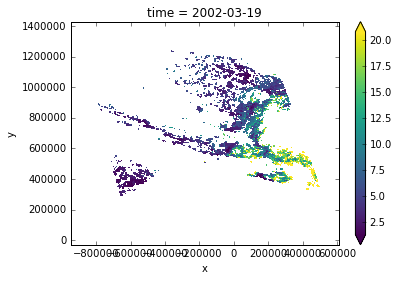

In [114]:
r.isel(time=0).plot(robust=True)

In [16]:
r.isel(time=0)

<xarray.DataArray (y: 1162, x: 1240)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
    time     datetime64[ns] 2003-04-08
Attributes:
    crs: +init=epsg:27700
    affine: (-947639.6305106485, 1256.543044095589, 0.0, 1429277.8120091753, 0.0, -1256.543044095589)

In [66]:
from tqdm import tqdm

In [67]:
import pandas as pd

100%|██████████| 14/14 [00:52<00:00,  3.51s/it]


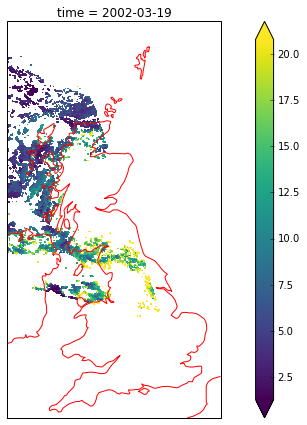

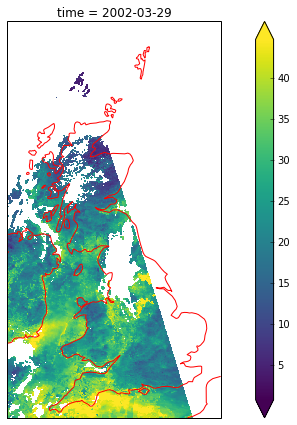

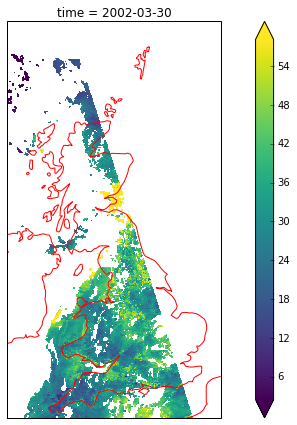

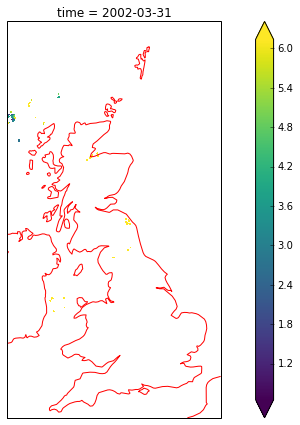

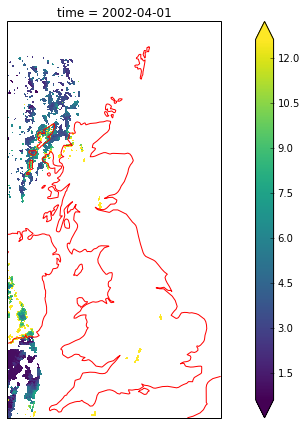

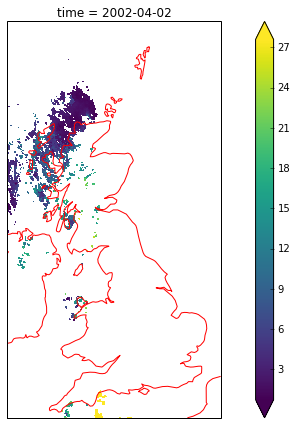

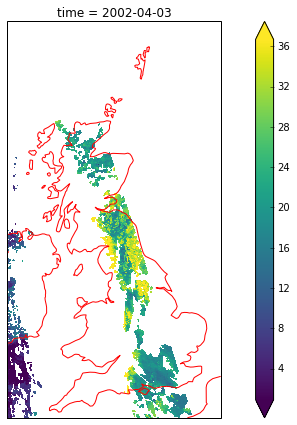

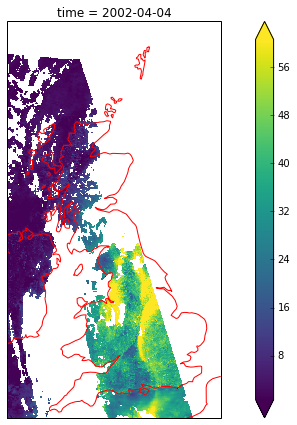

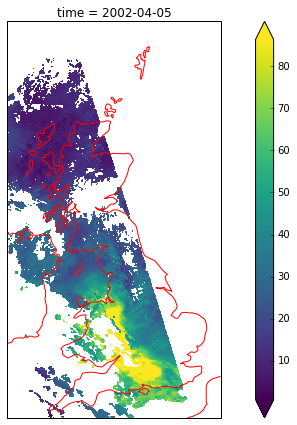

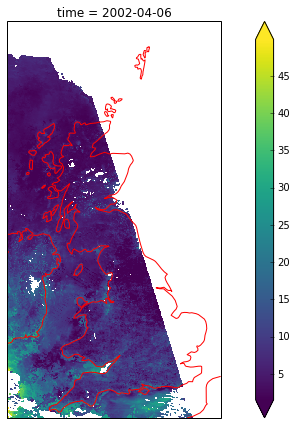

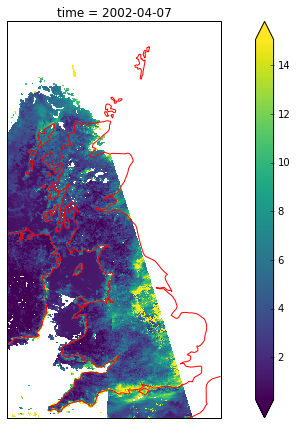

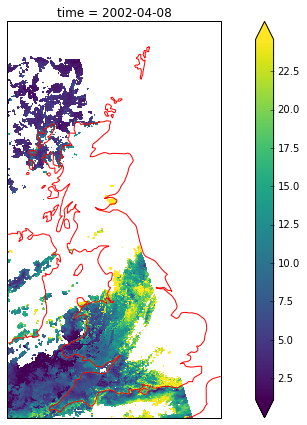

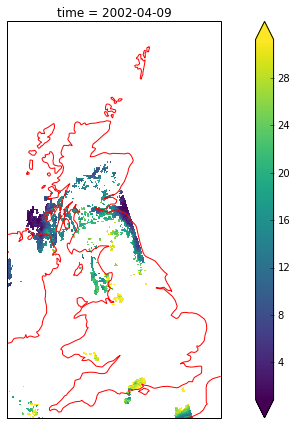

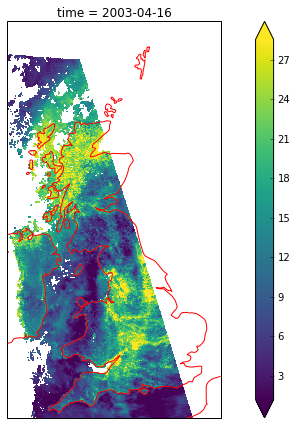

In [115]:
for i in tqdm(range(len(r.time))):
    figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.OSGB())
    ax.set_global()
    r.isel(time=i).plot(ax=ax, transform=ccrs.OSGB(), robust=True)
    ax.coastlines(resolution='50m', color='red')
    date_str = pd.to_datetime(r.isel(time=i).time.values).strftime('%Y-%m-%d')
    tight_layout()
    savefig(date_str + "_browse.png")

In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

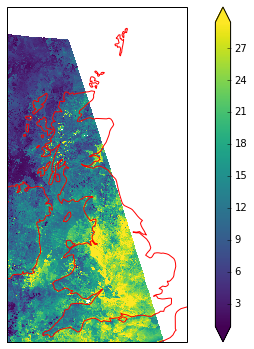

In [120]:
figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.OSGB())
ax.set_global()
overall_mean.plot(ax=ax, transform=ccrs.OSGB(), robust=True)
ax.coastlines(resolution='50m', color='red')
savefig('2002_OverallMean.png', bbox_inches='tight')

In [36]:
overall_max = r.max(dim='time', keep_attrs=True)

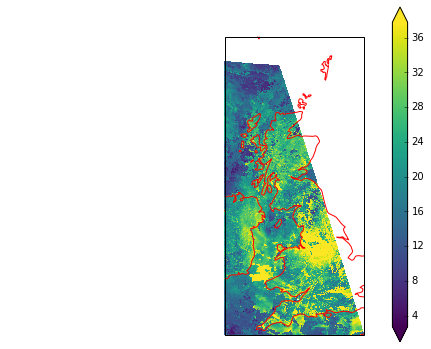

In [37]:
figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.OSGB())
overall_max.plot(ax=ax, transform=ccrs.OSGB(), robust=True)
ax.coastlines(resolution='50m', color='red')